## Predict permanent magnet synchronous motor (PMSM) rotor temperature with Fedot.Industrial

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. All recordings are sampled at 2 Hz. The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. This "sample" of ElectricMotorTemperature dataset was created by first splitting the measurement sessions into groups of 30 consecutive seconds, i.e. 60 timepoints. Then, used the **recorded ambient**, **coolant temperatures**, **d and q components of voltage**, **current** as predictors to form 6- dimensional time series of length 60. The target variable is the **maximum recorded rotor temperature during each respective 30-second time frame**. The resulting dataset has 22148 instances, of which 70% were sampled as training data and the remaining 30% as testing data.
Link to the dataset - https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

In [1]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
import matplotlib
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=15,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'ElectricMotorTemperature'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-04 13:46:46,637 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricMotorTemperature


In [5]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(15503, 6, 60)

Lets visualise our predictors.

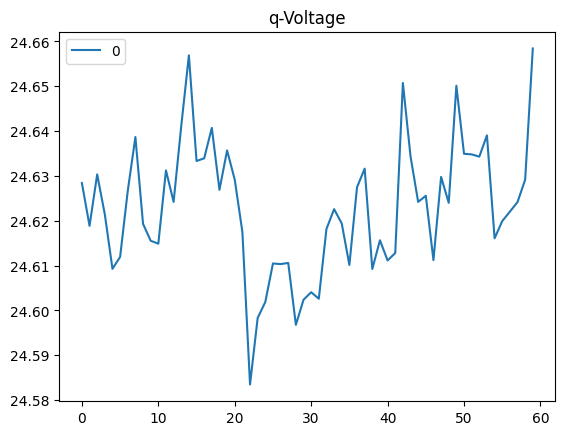

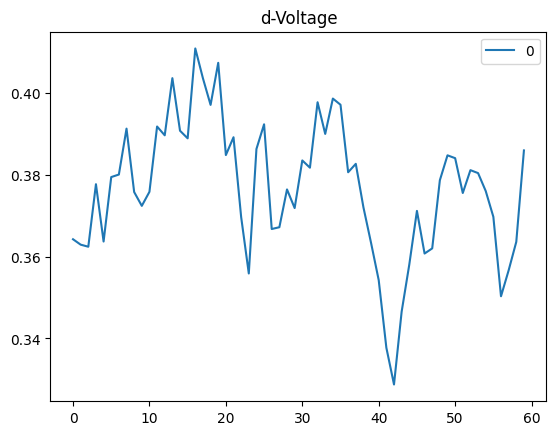

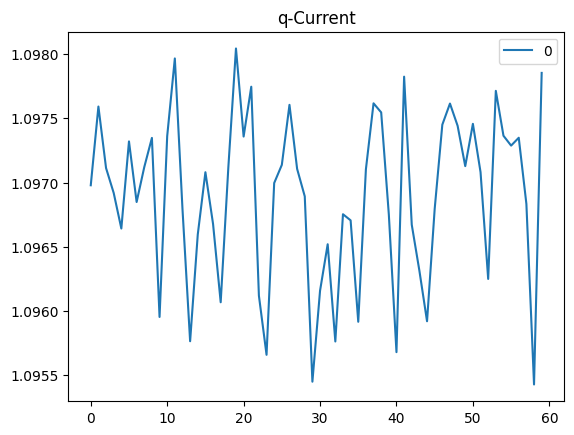

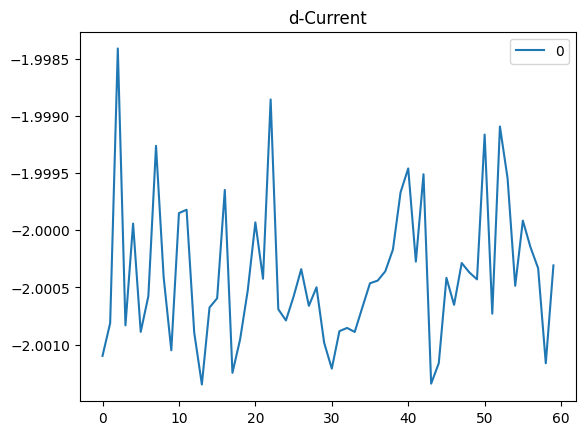

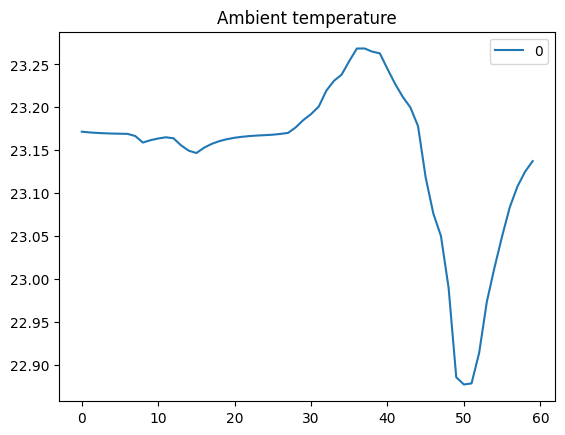

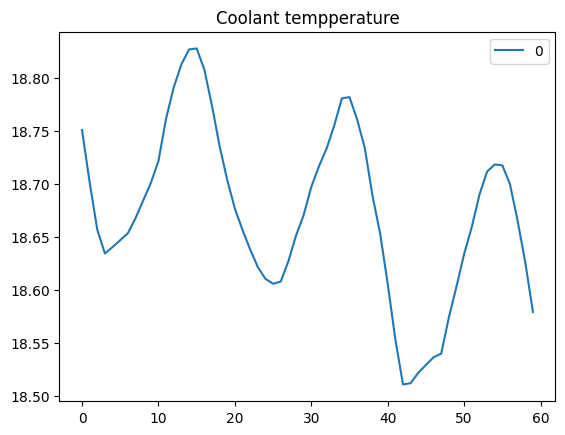

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='q-Voltage')
pd.DataFrame(features[1, 1, :]).plot(title='d-Voltage')
pd.DataFrame(features[1, 2, :]).plot(title='q-Current')
pd.DataFrame(features[1, 3, :]).plot(title='d-Current')
pd.DataFrame(features[1, 4, :]).plot(title='Ambient temperature')
pd.DataFrame(features[1, 5, :]).plot(title='Coolant tempperature')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [9]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_with_statistical_features,0.693983,112.378612,10.600878,7.958599,6.222807,0.694109,62.702171,0.502193
regression_pca_with_statistical_features,-0.000023,367.238547,19.163469,16.032184,14.537957,-0.000023,54.768756,-0.002806
regression_with_reccurence_features,0.039149,352.853347,18.784391,15.529970,13.787723,0.039151,56.811154,0.028607
regression_pca_with_reccurence_features,0.031494,355.664772,18.859077,15.617512,13.971815,0.031502,56.561991,0.023132
regression_with_topological_features,0.197249,294.794248,17.169573,13.730141,11.850148,0.197265,73.042515,0.141186
regression_pca_with_topological_features,0.197249,294.794248,17.169573,13.730141,11.850148,0.197265,73.042515,0.141186


In [10]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## AutoML approach

In [ ]:
metric_dict = {}
runs = 5
for run in range(runs):
    with IndustrialModels():
        auto_ml = PipelineBuilder().add_node('quantile_extractor',
                                              params={'window_size': 5}).add_node('fedot_regr',
                                                                             params={'timeout': 10,'logging_level':30}).build()
        auto_ml.fit(input_data)
        features = auto_ml.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in auto_ml.graph_description['nodes']})
        metric_dict.update({f'run_number - {run}':metric})

2023-10-12 15:29:10,559 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 297.5 MiB, max: 702.1 MiB
2023-10-12 15:29:10,569 - ApiComposer - Initial pipeline was fitted in 1565.6 sec.
2023-10-12 15:29:10,570 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-10-12 15:29:10,576 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['rfr', 'ridge', 'scaling', 'normalization', 'pca', 'catboostreg', 'xgbreg', 'svr', 'dtreg', 'treg', 'knnreg', 'fast_ica', 'kernel_pca', 'isolation_forest_reg', 'rfe_lin_reg', 'rfe_non_lin_reg'].
2023-10-12 15:29:10,578 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 1565.623006 sec.
2023-10-12 15:29:11,043 - ApiComposer - Model generation finished
2023-10-12 15:29:11,089 - FEDOT logger - Already fitted initial pipeline is used
2023-10-12 15:29:11,092 - FEDOT logger

In [ ]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

## Compare with State of Art (SOTA) models

In [179]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [180]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [ ]:
df['Fedot_Industrial_baseline'] = best_baseline
df['Fedot_Industrial_tuned'] = best_tuned
df['Fedot_Industrial_AutoML'] = 0
df = df.T

In [181]:
df.sort_values('min')

algorithm,min,max,average
FreshPRINCE_RMSE,1.020426,2.101253,1.490442
DrCIF_RMSE,1.046399,2.201153,1.594442
Fedot_Industrial_AutoML,1.049258,1.349887,1.158612
RotF_RMSE,1.097089,2.088333,1.559385
TSF_RMSE,1.172730,2.181236,1.684828
RandF_RMSE,1.182821,2.446314,1.708196
XGBoost_RMSE,1.272832,2.511297,1.716903
Fedot_Industrial_tuned,1.282551,1.282551,1.282551
RIST_RMSE,1.301506,1.887153,1.501047
RDST_RMSE,1.382981,2.200364,1.772813


In [182]:
df.sort_values('max')

algorithm,min,max,average
Fedot_Industrial_tuned,1.282551,1.282551,1.282551
Fedot_Industrial_AutoML,1.049258,1.349887,1.158612
Fedot_Industrial_baseline,1.538009,1.538009,1.538009
RIST_RMSE,1.301506,1.887153,1.501047
RotF_RMSE,1.097089,2.088333,1.559385
FreshPRINCE_RMSE,1.020426,2.101253,1.490442
MultiROCKET_RMSE,1.454406,2.137563,1.773578
TSF_RMSE,1.172730,2.181236,1.684828
RDST_RMSE,1.382981,2.200364,1.772813
DrCIF_RMSE,1.046399,2.201153,1.594442


In [183]:
df.sort_values('average')

algorithm,min,max,average
Fedot_Industrial_AutoML,1.049258,1.349887,1.158612
Fedot_Industrial_tuned,1.282551,1.282551,1.282551
FreshPRINCE_RMSE,1.020426,2.101253,1.490442
RIST_RMSE,1.301506,1.887153,1.501047
Fedot_Industrial_baseline,1.538009,1.538009,1.538009
RotF_RMSE,1.097089,2.088333,1.559385
DrCIF_RMSE,1.046399,2.201153,1.594442
TSF_RMSE,1.172730,2.181236,1.684828
RandF_RMSE,1.182821,2.446314,1.708196
XGBoost_RMSE,1.272832,2.511297,1.716903
